In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt


In [ ]:

def channel(G):
    return np.conj(np.transpose(G));
def AHA(A):
    return np.matmul(channel(A),A)

def AAH(A):
    return np.matmul(A,channel(A))

def mimo_capacity(Hmat, TXcov, Ncov):
    r, c = np.shape(Hmat);
    inLD = np.identity(r) + nl.multi_dot([nl.inv(Ncov),Hmat,TXcov,channel(Hmat)]);
    C = np.log2(nl.det(inLD));
    return np.abs(C)


def ArrayDictionary(G,t):
    lxx = 2/G*np.arange(G)-1;
    lx, kx = np.meshgrid(lxx, np.arange(t))
    omega = np.exp(-1j*np.pi)
    dmtx = 1/np.sqrt(t)*np.power(omega,kx*lx)
    return dmtx

def SOMP(Opt, Dict, Ryy, numRF):
    rq, cq = np.shape(Dict);
    Res = Opt;
    RF = np.zeros((rq,numRF))+1j*np.zeros((rq,numRF));
    for iter1 in range(numRF):
        phi = nl.multi_dot([channel(Dict),Ryy,Res]);
        phi_phiH = AAH(phi);
        m_ind = np.argmax(np.abs(np.diag(phi_phiH)));
        RF[:,iter1] = Dict[:,m_ind];
        RFc = RF[:,0:iter1+1];
        BB = nl.multi_dot([nl.inv(nl.multi_dot([channel(RFc),Ryy,RFc])),channel(RFc),Ryy,Opt]);
        Res = (Opt-np.matmul(RFc,BB))/nl.norm(Opt-np.matmul(RFc,BB));
    return  BB, RF

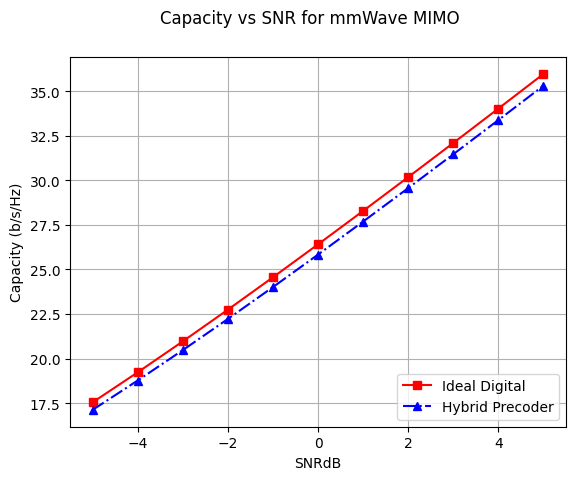

In [ ]:

# simulation parameters
t = 32; r = 32;
numRF = 6;
G = 64;
L = 8;  # No. of multipath component (number of clusters/scatterers)
Ns = 6;
ITER = 100;

# Initializations
SNRdB = np.arange(-5,6,1);
C_HYB = np.zeros(len(SNRdB));
C_MIMO = np.zeros(len(SNRdB));

# G-quantized Txarray response matrix
A_T = ArrayDictionary(G,t);
A_R = ArrayDictionary(G,r);

for ix in range(ITER):
    # print(ix);

    # Channel generation
    tax = np.random.choice(G, L, replace=False);
    rax = np.random.choice(G, L, replace=False);
    chGain = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
    A_T_channel = A_T[:, tax];
    A_R_channel = A_R[:, rax];
    H = np.sqrt(t*r/L)*nl.multi_dot([A_R_channel,np.diag(chGain),channel(A_T_channel)]);

    U, S, VH = nl.svd(H, full_matrices=True)

    V = channel(VH)
    Fopt = V[:,0:Ns];
    FBB, FRF = SOMP(Fopt, A_T, np.identity(t), numRF);
    FBB_NORM = FBB*np.sqrt(Ns)/nl.norm(np.matmul(FRF,FBB));
    for cx in range(len(SNRdB)):
        npow = 10**(-SNRdB[cx]/10);
        mmseINV = nl.inv(AHA(np.matmul(H,Fopt)) + npow*Ns*np.identity(Ns));
        Wmmse_opt = nl.multi_dot([H,Fopt,mmseINV]);
        C_MIMO[cx] = C_MIMO[cx] + \
        mimo_capacity(nl.multi_dot([channel(Wmmse_opt),H,Fopt]), 1/Ns*np.identity(Ns), npow*AHA(Wmmse_opt));
        HFp = nl.multi_dot([H,FRF,FBB_NORM]);
        Ryy = 1/Ns*AAH(HFp) + npow*np.identity(r);
        Wmmse_Hyb = np.matmul(HFp,nl.inv(AHA(HFp) + npow*Ns*np.identity(Ns)));
        WBB, WRF = SOMP(Wmmse_Hyb, A_R, Ryy, numRF);
        C_HYB[cx] = C_HYB[cx] + \
        mimo_capacity(nl.multi_dot([channel(WBB),channel(WRF),H,FRF,FBB_NORM]), 1/Ns*np.identity(Ns), npow*AHA(np.matmul(WRF,WBB)));

C_MIMO = C_MIMO/ITER; C_HYB = C_HYB/ITER;
plt.plot(SNRdB, C_MIMO,'r-s');
plt.plot(SNRdB, C_HYB,'b^-.');
plt.grid(1,which='both')
plt.legend(["Ideal Digital", "Hybrid Precoder"], loc ="lower right");
plt.suptitle('Capacity vs SNR for mmWave MIMO')
plt.ylabel('Capacity (b/s/Hz)')
plt.xlabel('SNRdB')
plt.show()